In [1001]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import warnings
warnings.filterwarnings("ignore")
import pickle
import wordcloud 
import spacy
import spacy.lang.pt
import string

from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from unicodedata import normalize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Classifica_Spam
Esse projeto é um classificador que separa mensagens que são spam das que não são.

## Problema
Quem nunca se deparou com uma caixa de entrada cheia de Spams? Spams podem não ser apenas irritantes, mas também um problema por causar um desperdício de tempo sempre que você precisa selecionar individualmente cada email e classificá-lo manualmente. Pensando nisso, surgiu a ideia do projeto Classifica_Spam que utiliza ferramentas de machine learning para fazer essa classificação de forma automática. 

## Análise exploratória 
- Aqui o importante é o entendimento do Dataset seguindo os passos:

        Checagem dos tipos de dados;         
        Formato do Dataset; 
        Presença de valores duplicados;
        Presença de valores nulos. 
        

In [1002]:
path = Path() / '..'/ 'data' / 'processed_utf8' / 'Data_Train_utf.xlsx'
df = pd.read_excel(path)
df.head()

,ID,Message,SPAM
0,615317,Linda msg!,True
1,855344,To fazendo batida de kwui com coco,True
2,1007222,Esse dinheiro só vai sair para quem está com o...,True
3,811063,Isso msm Irmã.. nao lembrava dos nomes kkk,True
4,913944,Ai xara eu sujiro esse,True


In [1003]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1773 entries, 0 to 1772
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID       1773 non-null   int64 
 1   Message  1773 non-null   object
 2   SPAM     1773 non-null   bool  
dtypes: bool(1), int64(1), object(1)
memory usage: 29.6+ KB


In [1004]:
df.shape

(1773, 3)

In [1005]:
#eliminando dados duplicados
df.drop_duplicates(inplace=True)

In [1006]:
#checando nulos
df.isnull().sum()

ID         0
Message    0
SPAM       0
dtype: int64

A análise exploratória resultou na percepção de caracteres especiais. 
O excel utliza caracteres não reconhecidos na importação, eles são encodados com um número hexadecimal de 4 dígitos, envoltos por um x e um underscore de cada lado (_x000d_). Vamos limpar o df removendo esses caracteres que não tem significado para a análise.
Também serão removidos caracteres que constam com a nomenclatura '&#x2f'.

In [1007]:
df = df.replace({r"_x[0-9A-F]{4}_":""}, regex=True)
df = df.replace({r"&#x[0-9A-F]{2};":""}, regex=True)              

### Salvando uma cópia do Dataset original

In [1008]:
data = df.copy()
data.head()

,ID,Message,SPAM
0,615317,Linda msg!,True
1,855344,To fazendo batida de kwui com coco,True
2,1007222,Esse dinheiro só vai sair para quem está com o...,True
3,811063,Isso msm Irmã.. nao lembrava dos nomes kkk,True
4,913944,Ai xara eu sujiro esse,True


## Distribuição dos dados

Agora já podemos checar como estão distribuídos os dados e calcular a razão entre Spam e não-Spam

In [1009]:
df['SPAM'].value_counts()

True     932
False    841
Name: SPAM, dtype: int64

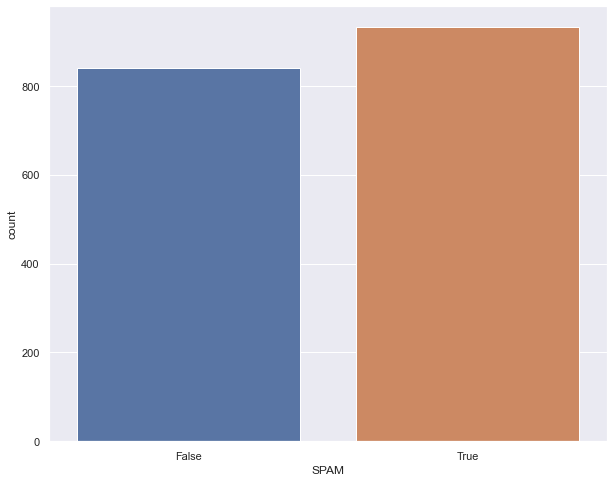

In [1010]:
sns.countplot(df['SPAM'])
plt.show()

O plot acima mostra que o conjunto de dados está balanceado

### Convertendo a coluna 'SPAM' para forma numérica

In [1011]:
df['SPAM_int'] = df['SPAM'].map({True:1, False:0})

In [1012]:
df

,ID,Message,SPAM,SPAM_int
0,615317,Linda msg!,True,1
1,855344,To fazendo batida de kwui com coco,True,1
2,1007222,Esse dinheiro só vai sair para quem está com o...,True,1
3,811063,Isso msm Irmã.. nao lembrava dos nomes kkk,True,1
4,913944,Ai xara eu sujiro esse,True,1
...,...,...,...,...
1768,521420,Meu nome e alex sandro,True,1
1769,791210,Hum\nTenho ums aki\nN\nTenhos ums piso aki\nE ...,True,1
1770,1031770,Quem tem padrinho não morre pagão\nQuem tem pa...,True,1
1771,580122,ALUNO QUE PROCESSOU PROFESSOR POR TER TOMADO C...,True,1


# Construindo a word cloud dos termos mais comuns

Nesta fase vamos fazer a nuvem de palavras, para isso é necessário um tratamento prévio no texto, para remoção de caracteres que não possuem valor semântico. Aqui nós iremos:

- Definir stop words;
- Remover stop words;
- Construir uma nuvem de palavras para todos os termos do Dataset;
- Construir uma nuvem de palavras para os termos presentes nas mensagens não SPAM;
- Construir uma nuvem de palavras para os termos presentes nas mensagens SPAM.

*Foram adicionados termos extra ao conjunto de stop words pré definido pelo nltk.

In [1013]:
#Adicionando palavras às preexistentes na biblioteca nltk_stopwords
nltk_stopwords = stopwords.words('portuguese') + ["da", "meu", "em", "de", "ao", "os", "para", "vai", "pra"]

In [1014]:
#Checagem se as palavras novas foram adicionadas corretamente
nltk_stopwords

['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'às',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'é',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'éramos',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'está',
 'estamos',
 'estão',
 'estar',
 'estas',
 'estava',
 'estavam',
 'estávamos',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estivéramos',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéssemos',
 'estou',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'fôramos',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fôssemos',
 'fui',
 'há',
 'haja',
 'hajam',
 'hajamos',
 'hão',
 'havemos',
 'haver',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houverá',
 'houveram',
 'houvéramos',
 'houverão',
 'houverei',
 'houverem',
 'hou

### Removendo stop words e caracteres indesejados

As funções remove_stopwords e normalizaTexto foram aplicadas para, respectivamente, retirar as stop words presentes no texto, e remover caracteres indesejados.

In [1015]:
def remove_stopwords(texto):    
    novo_texto = []
    tokens = nltk.word_tokenize(texto)
    for token in tokens:        
        if len(token) > 2 and token not in nltk_stopwords:
            novo_texto.append(token)
    output = ' '.join(novo_texto)
    return output

In [1016]:
def normalizaTexto(texto):    
    output = re.sub(r'[-.;?!:,"()\']','', texto)
    output = remove_stopwords(output)
    output = normalize('NFKD', output).encode('ASCII', 'ignore').decode('ASCII')
    return output.lower()

In [1017]:
#Simples checagem se a função 'normalizaTexto' funcionou, observando a primeira linha do Dataset
texto = df['Message'].iloc[0]

In [1018]:
normalizaTexto(texto)

'linda msg'

In [1019]:
#Aplicação da função 'normalizatexto' na coluna 'Message'
df['text_norm'] = df['Message'].apply(normalizaTexto)

In [1020]:
df

,ID,Message,SPAM,SPAM_int,text_norm
0,615317,Linda msg!,True,1,linda msg
1,855344,To fazendo batida de kwui com coco,True,1,fazendo batida kwui coco
2,1007222,Esse dinheiro só vai sair para quem está com o...,True,1,esse dinheiro sair nome lista esse dinheiro sa...
3,811063,Isso msm Irmã.. nao lembrava dos nomes kkk,True,1,isso msm irma nao lembrava nomes kkk
4,913944,Ai xara eu sujiro esse,True,1,xara sujiro
...,...,...,...,...,...
1768,521420,Meu nome e alex sandro,True,1,meu nome alex sandro
1769,791210,Hum\nTenho ums aki\nN\nTenhos ums piso aki\nE ...,True,1,hum tenho ums aki tenhos ums piso aki divisoria
1770,1031770,Quem tem padrinho não morre pagão\nQuem tem pa...,True,1,quem padrinho morre pagao quem padrinho morre ...
1771,580122,ALUNO QUE PROCESSOU PROFESSOR POR TER TOMADO C...,True,1,aluno que processou professor por ter tomado c...


A junção de todas as mensagens de 'text_norm' forma um grande texto sem quebras (representado por 'big_text'), onde será gerada a primeira word cloud, sem distinção de SPAM e não SPAM.

In [1021]:
#Gerando um texto contínuo
big_text = ' '.join(text for text in df['text_norm'])

In [1022]:
big_text

'linda msg fazendo batida kwui coco esse dinheiro sair nome lista esse dinheiro sair nome lista isso msm irma nao lembrava nomes kkk xara sujiro muito bom add vcs bom dia sou nova friburgo nao perco programa acordo vcs barata andando supermercados extra pilares nao primeira vez tipo coisa acontece sua cachorrera responde esperar tony ent nao assisto filme bom dia bom dia rio noticiando reportagem sobre saude publica hospital aluisio cardoso veiculou informacao paciente enviou msg bilhete informando comprar medicamento sildenafila pois hospital disponivel tratase principio ativo cialis medicamento disfuncao eretil acho tao grave filial capixaba famosa churrascaria porcao portas fechadas funcionarios iniciaram mobilizacao requerer salarios atrasados segundo advogada representa maioria empregados situacao arrastando ano aconteceu pagamento sair dias atraso desta vez passaram tres meses afirma marta rose vimercati advogada diz atraso parte problemas alguns casos sendo recolhidos fgts inss 

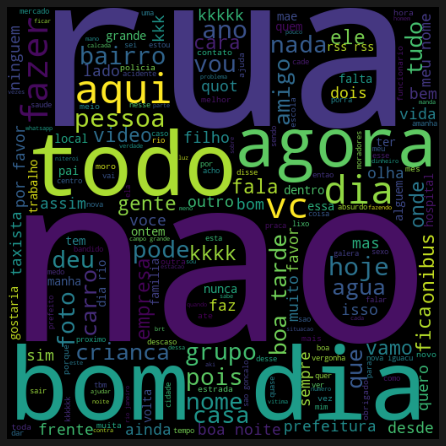

In [1023]:
#Word cloud com todas as palavras
big_text_cloud = WordCloud(width = 512, height = 512).generate(big_text)

plt.figure(figsize = (7,6), facecolor = 'k')
plt.imshow(big_text_cloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

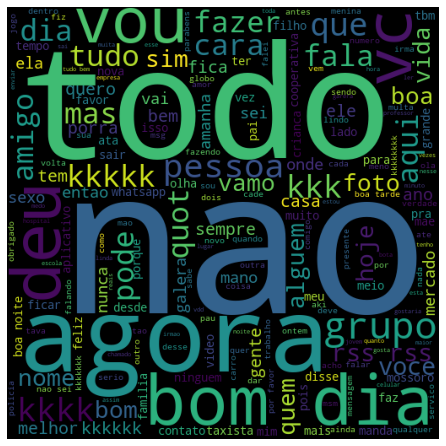

In [1024]:
#Word cloud para mensagens não SPAM

no_spam_words = ' '.join(df[df['SPAM'] == True ]['text_norm'])
no_spam = WordCloud(width = 512, height = 512).generate(no_spam_words)

plt.figure(figsize = (7,6), facecolor = 'w')
plt.imshow(no_spam)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

A nuvem de palavras mostra que um caractere _x000d_ ocorre de forma frequente, este representa um caractere de linha '\n' que foi gerando quando o arquivo foi salvo no formato utf8. Então, este argumento serár etirado do texto.
Limpando caracteres unicode do excel não reconhecidos.

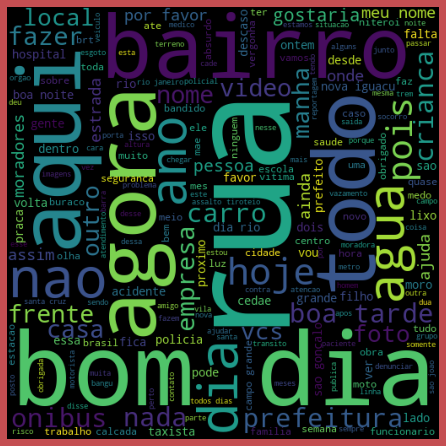

In [1025]:
#Word cloud das mensagens SPAM

spam_words = ' '.join(df[df['SPAM'] == False ]['text_norm'])
spam_wc = WordCloud(width = 512, height = 512).generate(spam_words)

plt.figure(figsize = (7,6), facecolor = 'r')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

## Tokenização

A tokenização dividirá o texto em pequenos pedaços. Ela quebra o texto em palavras chamadas tokens. Esses tokens ajudam a entender o contexto ou desenvolver o modelo para a PNL. A tokenização ajuda na interpretação do significado do texto, analisando a sequência das palavras.

In [1026]:
#Aplicando a função para Tokenização
def tokenize(text):
    tokens = re.split("\W+", text)# W+ - Qualquer caractere de palavra 0-9 a-z A-Z
    return tokens

df["text_tokenized"] = df["text_norm"].apply(tokenize)

df.head()

,ID,Message,SPAM,SPAM_int,text_norm,text_tokenized
0,615317,Linda msg!,True,1,linda msg,"[linda, msg]"
1,855344,To fazendo batida de kwui com coco,True,1,fazendo batida kwui coco,"[fazendo, batida, kwui, coco]"
2,1007222,Esse dinheiro só vai sair para quem está com o...,True,1,esse dinheiro sair nome lista esse dinheiro sa...,"[esse, dinheiro, sair, nome, lista, esse, dinh..."
3,811063,Isso msm Irmã.. nao lembrava dos nomes kkk,True,1,isso msm irma nao lembrava nomes kkk,"[isso, msm, irma, nao, lembrava, nomes, kkk]"
4,913944,Ai xara eu sujiro esse,True,1,xara sujiro,"[xara, sujiro]"


## Lematização

Com a lematização se busca reduzir a palavra à sua raiz, retirando todas as inflexões e chegando ao 'lema'. Porém, essa redução sempre resultará em uma palavra que realmente existe na gramática. Outro ponto importante é que, nessa técnica, a classe gramatical da palavra será levada em consideração para fazer a redução.

In [1027]:
wn = nltk.WordNetLemmatizer()

def lemmatizer(t_text):
    text = [wn.lemmatize(word) for word in t_text]
    return text

df["text_lemmatized"] = df["text_tokenized"].apply(lemmatizer)
df.head()

,ID,Message,SPAM,SPAM_int,text_norm,text_tokenized,text_lemmatized
0,615317,Linda msg!,True,1,linda msg,"[linda, msg]","[linda, msg]"
1,855344,To fazendo batida de kwui com coco,True,1,fazendo batida kwui coco,"[fazendo, batida, kwui, coco]","[fazendo, batida, kwui, coco]"
2,1007222,Esse dinheiro só vai sair para quem está com o...,True,1,esse dinheiro sair nome lista esse dinheiro sa...,"[esse, dinheiro, sair, nome, lista, esse, dinh...","[esse, dinheiro, sair, nome, lista, esse, dinh..."
3,811063,Isso msm Irmã.. nao lembrava dos nomes kkk,True,1,isso msm irma nao lembrava nomes kkk,"[isso, msm, irma, nao, lembrava, nomes, kkk]","[isso, msm, irma, nao, lembrava, nome, kkk]"
4,913944,Ai xara eu sujiro esse,True,1,xara sujiro,"[xara, sujiro]","[xara, sujiro]"


## Analisando o tamanho das mensagens e percentagem de pontos
- Em busca de diferenciar SPAM e não SPAM, serão aplicadas técnicas que agrupam mensagens SPAM e não SPAM, observando se há diferença de comportamento para cada tipo de mensagem em relação ao seu tamanho e frequência de pontuação. 

In [1028]:
df['Message_len'] = df['Message'].apply(lambda x: len(x) - x.count(" "))

df.head()

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

df['punct%'] = df['Message'].apply(count_punct)

df.head()

,ID,Message,SPAM,SPAM_int,text_norm,text_tokenized,text_lemmatized,Message_len,punct%
0,615317,Linda msg!,True,1,linda msg,"[linda, msg]","[linda, msg]",9,11.1
1,855344,To fazendo batida de kwui com coco,True,1,fazendo batida kwui coco,"[fazendo, batida, kwui, coco]","[fazendo, batida, kwui, coco]",28,0.0
2,1007222,Esse dinheiro só vai sair para quem está com o...,True,1,esse dinheiro sair nome lista esse dinheiro sa...,"[esse, dinheiro, sair, nome, lista, esse, dinh...","[esse, dinheiro, sair, nome, lista, esse, dinh...",113,7.1
3,811063,Isso msm Irmã.. nao lembrava dos nomes kkk,True,1,isso msm irma nao lembrava nomes kkk,"[isso, msm, irma, nao, lembrava, nomes, kkk]","[isso, msm, irma, nao, lembrava, nome, kkk]",35,5.7
4,913944,Ai xara eu sujiro esse,True,1,xara sujiro,"[xara, sujiro]","[xara, sujiro]",18,0.0


Avaliando distribuição dos tamanhos das palavras e presença de pontuação em Spam e não Spam

In [1029]:
#Quantidade de caracteres em Spam e não Spam
df.groupby('SPAM')['Message_len'].sum()

SPAM
False    134688
True     132584
Name: Message_len, dtype: int64

In [1030]:
#Quantidade de pontuação em Spam e não Spam
df.groupby('SPAM')['punct%'].sum()

SPAM
False    2224.8
True     2558.6
Name: punct%, dtype: float64

Para facilitar a visualização da distribuição individual para o número de caracteres e pontuação, dois histogramas serão utilizados.

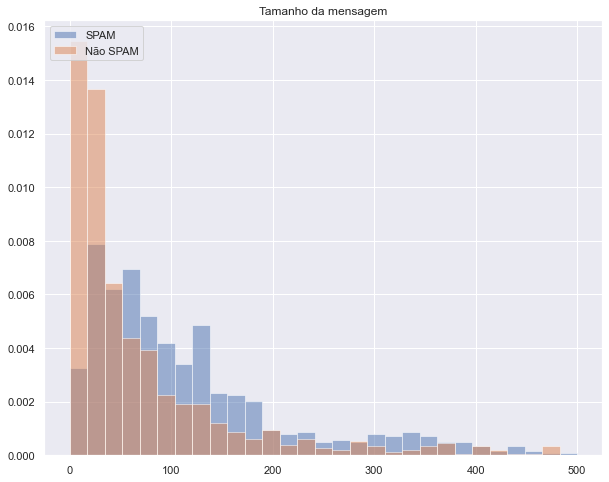

In [1031]:
#Histograma tamanho da mensagem
sns.set(rc= {"figure.figsize": (10, 8)})

bins = np.linspace(0, 500, 30)

plt.hist(df[df['SPAM_int']==0]['Message_len'], bins, alpha=0.5, density=True, label='SPAM')
plt.hist(df[df['SPAM_int']==1]['Message_len'], bins, alpha=0.5, density=True, label='Não SPAM')
plt.legend(loc='upper left')
plt.title('Tamanho da mensagem')
plt.show()

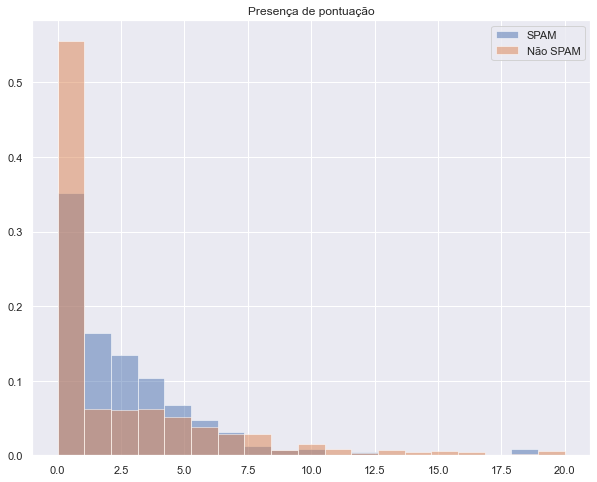

In [1032]:
#Histograma presença de pontuação
sns.set(rc= {"figure.figsize": (10, 8)})

bins = np.linspace(0, 20, 20)

plt.hist(df[df['SPAM_int']==0]['punct%'], bins, alpha=0.5, density=True, label='SPAM')
plt.hist(df[df['SPAM_int']==1]['punct%'], bins, alpha=0.5, density=True, label='Não SPAM')
plt.legend(loc='upper right')
plt.title('Presença de pontuação')
plt.show()

### Analisando as palavras mais frequentes para Spam e não Spam

In [1033]:
count1 = Counter(" ".join(df[df['SPAM_int']==1]["text_norm"]).split()).most_common(30)
data1 = pd.DataFrame.from_dict(count1)
data1 = data1.rename(columns={0: "words of ham", 1 : "count"})
count2 = Counter(" ".join(df[df['SPAM_int']==0]["text_norm"]).split()).most_common(30)
data2 = pd.DataFrame.from_dict(count2)
data2 = data2.rename(columns={0: "words of spam", 1 : "count_"})

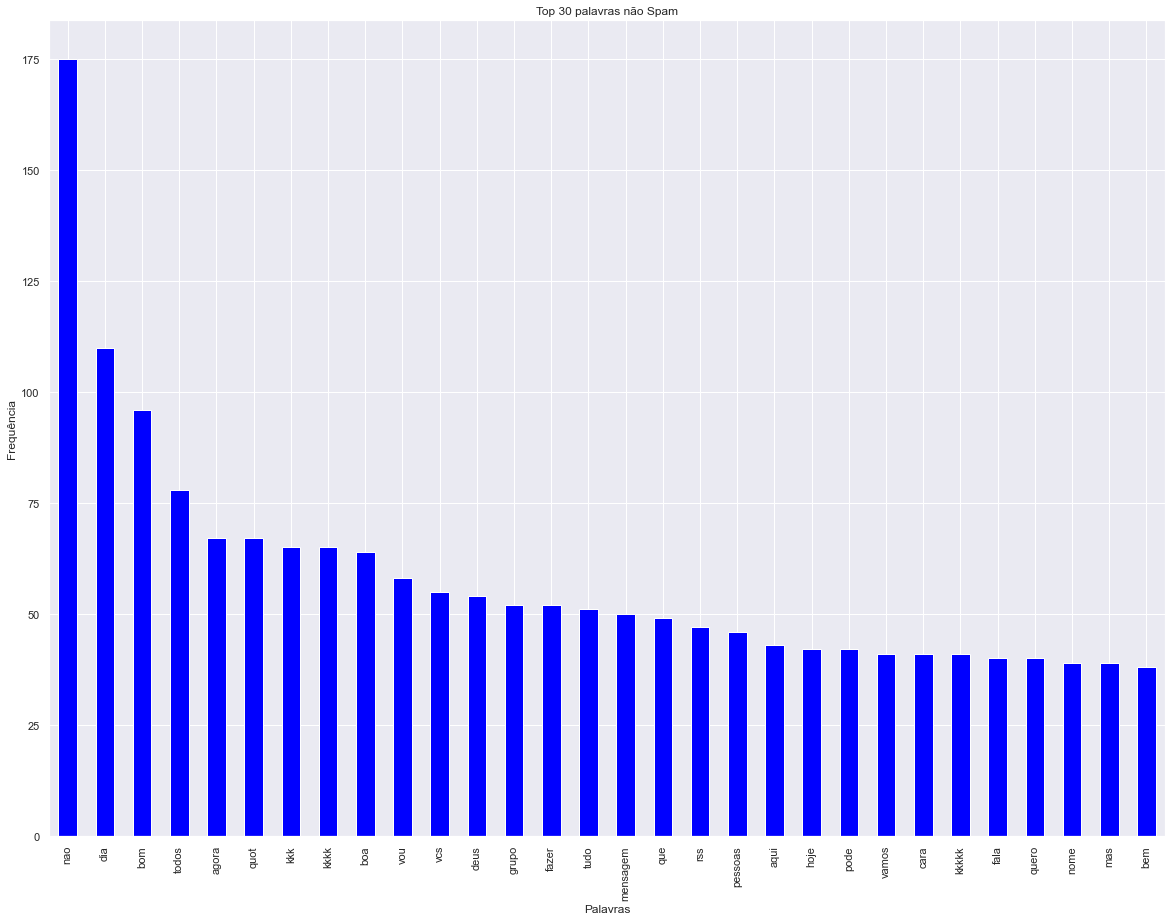

In [1034]:
#Gráfico de barras das palavras mais comuns não Spam
data1.plot.bar(legend = False, color = 'blue',figsize = (20,15))
y_pos = np.arange(len(data1["words of ham"]))
plt.xticks(y_pos, data1["words of ham"])
plt.title('Top 30 palavras não Spam')
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.show()

As palavras mais comuns em textos não SPAM mostram a informalidade das mensagens. Se destaca como palavra mais comum em mensagens não SPAM 'xd000_'. Possivelmente é um erro gerado por emoticons ou imagens em mensagens. Esta característica é marcante em mensagens não SPAM.

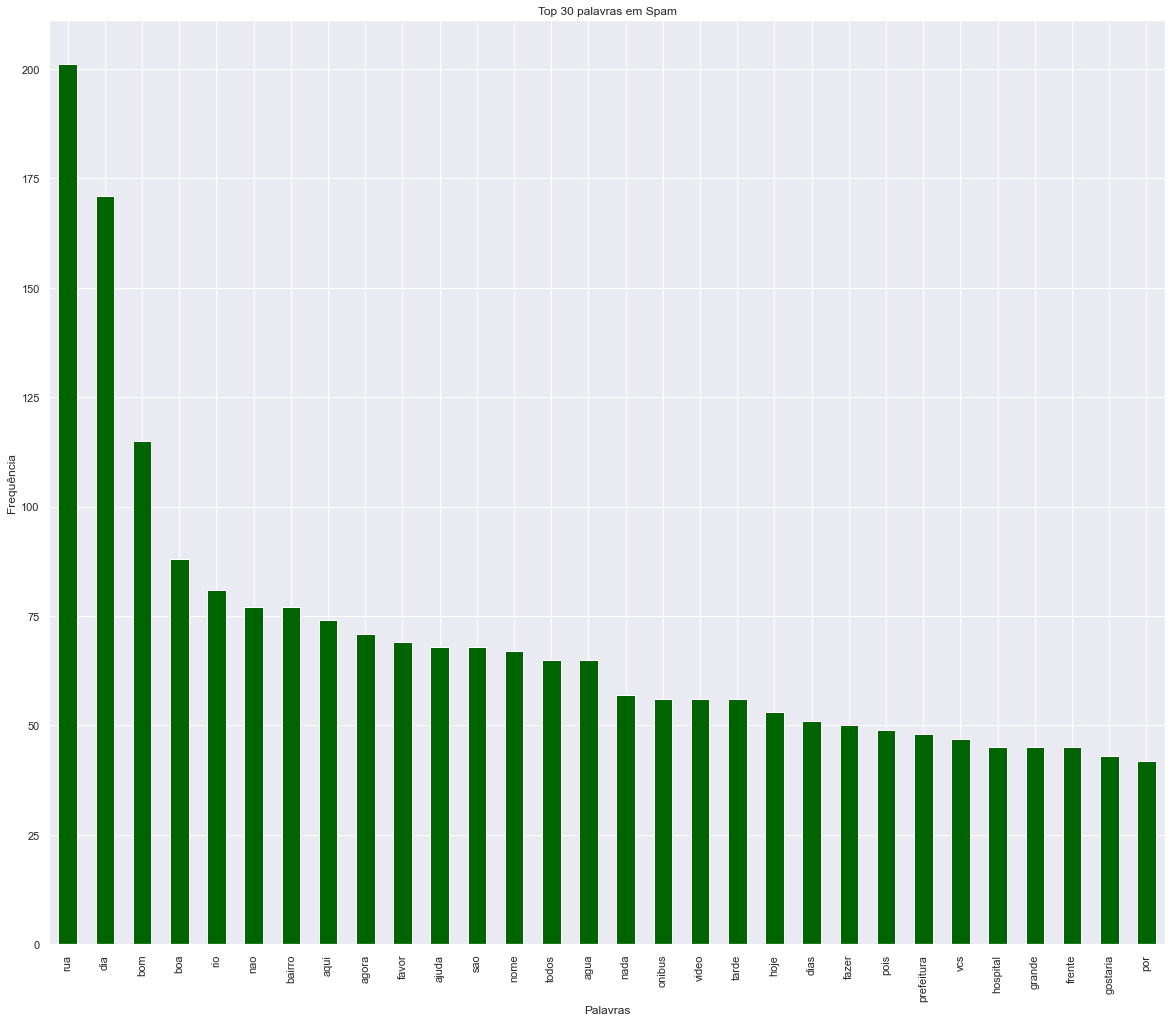

In [1035]:
#Gráfico de barras das palavras mais comuns Spam
data2.plot.bar(legend = False, color = 'darkgreen', figsize = (20,17))
y_pos = np.arange(len(data2["words of spam"]))
plt.xticks(y_pos, data2["words of spam"])
plt.title('Top 30 palavras em Spam')
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.show()

In [1036]:
#df.to_pickle('C:\\Users\\Thiag\\spam_ham\\data\\dataframe_to_modeling\\spam_ham.pickle')

Como esperado, o texto de mansagens SPAM contém em destaque palavras como 'Rua' (possível endereço para encontrar o serviço oferecido), 'bom' e 'dia', que representam saudações recorrentes nesses tipos de mensagens.

## Avaliação de precisão do modelo

- Precisão: qual a proporção dos dados classificados como SPAM eram realmente SPAM. (falsos positivos)

- Recall: entre todas as amostras que realmente eram de SPAM, qual a proporção classificada como SPAM. (falsos negativos)

- F1-score: uma maneira de observar em um único número a precisão e o recall.


In [1037]:
lr_model = lr.fit(X_train_vect, y_train)

y_pred = lr_model.predict(X_test_vect)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label=False, average='binary')
print('Precision: {} / Recall: {} / F1-Score: {}'.format(
round(precision, 3), round(recall, 3), round(fscore,3)))

Precision: 0.835 / Recall: 0.821 / F1-Score: 0.828


In [1038]:
lr_model = lr.fit(X_train_vect, y_train)

y_pred = lr_model.predict(X_test_vect)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label=True, average='binary')
print('Precision: {} / Recall: {} / F1-Score: {}'.format(
round(precision, 3), round(recall, 3), round(fscore,3)))

Precision: 0.842 / Recall: 0.854 / F1-Score: 0.848
